# Sky noise distribution check

> Check that the error-normalised sky-subtracted flux in sky fibres resembles a standard Normal distribution.

In [ ]:
# |default_exp diagnostics.sky_noise_distribution_check

In [ ]:
# |hide

# This prevents warnings from appearing in cell outputs, since it has proved difficult
# to suppress warnings arising from dask workers.
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


In [ ]:
# |export

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from dask.distributed import Client
from scipy.stats import sigmaclip

from qagmire.data import get_weave_files, read_fibre_table_nspec, read_l1_data
from qagmire.quality_assurance import Diagnostics
from qagmire.utilities import ks_norm_prob

To write checks of the data, we create a subclass of `Diagnostics` and implement the `tests` method.

In [ ]:
# |export


class SkyNoiseDistributionCheck(Diagnostics):
    """Sky noise distribution check.

    A reproduction of the NoisePropCheck classes in the weaveio
    [noise_prop_checks](https://github.com/bamford/QAG/blob/master/diagnostics/noise_prop_checks.py).

    This tests for the following case:

    * Is the mean of the normalised flux in sky fibres significantly different from zero?
    * Is the standard deviation of the normalised flux in sky fibres significantly different from unity?
    * Does the distribution of normalised flux in sky fibres fail a KS test comparison with a standard Normal?

    for "single" and "stack" L1 spectra and for the red and blue cameras.
    """

    def __init__(
        self,
        ks_pvalue_limit: float = 0.01,  # the pvalue below which distributions are considered to differ
        mean_sig_limit: float = 5,  # the significance above which means are considered to differ
        stdev_sig_limit: float = 5,  # the significance above which stdevs are considered to differ
        stack=False,  # if True, check the stack spectra, otherwise check the single spectra
        camera=None,  # limit to a specific camera: RED or BLUE
        **kwargs,  # additional keyword arguments are passed to the `Diagnostics` constructor
    ):
        self.ks_pvalue_limit = ks_pvalue_limit
        self.mean_sig_limit = mean_sig_limit
        self.stdev_sig_limit = stdev_sig_limit
        self.stack = stack
        self.camera = camera.upper() if camera is not None else None
        super().__init__(**kwargs)

    def tests(self, **kwargs):
        filetype = "stack" if self.stack else "single"
        files = get_weave_files(level="L1", lowres=True, filetype=filetype, **kwargs)
        data = read_l1_data(files)

        fibre_table = read_fibre_table_nspec(files)
        data = xr.merge((data, fibre_table))
        data = data.where(data["TARGUSE"] == b"S", drop=True)

        if self.camera is not None:
            camera_match = data["CAMERA"] == self.camera
            data = data.sel(filename=camera_match)
            cameras = [self.camera]
        else:
            cameras = ["RED", "BLUE"]

        # perform the tests by RUN, rather than filename
        data = data.swap_dims(filename="RUN")
        self.data = data

        stats = []
        for camera in cameras:
            camera_match = data["CAMERA"] == camera
            flux, ivar = f"{camera}_FLUX", f"{camera}_IVAR"
            camdata = data[[flux, ivar]].sel(RUN=camera_match)
            camdata = camdata.where(camdata[ivar] > 0)
            camdata = camdata.stack(SPEC=("RUN", "NSPEC"))
            normflux = camdata[flux] * np.sqrt(camdata[ivar])
            exdim = [d for d in normflux.dims if d != "SPEC"][0]
            check_stats = xr.Dataset()
            n = normflux.count(exdim)
            check_stats["stdev_measured"] = camdata[flux].std(exdim, ddof=1)
            check_stats["stdev_expected"] = np.sqrt((1 / camdata[ivar]).mean(exdim))
            check_stats["mean_zscore"] = normflux.mean(exdim)
            check_stats["stdev_zscore"] = normflux.std(exdim, ddof=1)
            check_stats["err_on_mean_zscore"] = check_stats["stdev_zscore"] / np.sqrt(n)
            check_stats["err_on_stdev_zscore"] = check_stats["stdev_zscore"] / np.sqrt(
                2 * n - 2
            )
            check_stats["sig_mean_zscore"] = (
                abs(check_stats["mean_zscore"]) / check_stats["err_on_mean_zscore"]
            )
            check_stats["sig_stdev_zscore"] = (
                abs(check_stats["stdev_zscore"] - 1)
                / check_stats["err_on_stdev_zscore"]
            )
            check_stats["ks_prob"] = ks_norm_prob(normflux)
            stats.append(check_stats)
        check_stats = xr.concat(stats, "SPEC")
        self.stats = check_stats
        check_stats = check_stats.unstack("SPEC")
        # remove apparent dependence of other coords on NSPEC
        for x in check_stats.coords:
            if x not in ("RUN", "NSPEC"):
                check_stats[x] = check_stats[x].isel(NSPEC=0)

        tests = [
            {
                "name": "mean_non_zero",
                "description": "Is the mean of the normalised flux in sky fibres "
                "significantly different from zero?",
                "test": (check_stats["sig_mean_zscore"] > self.mean_sig_limit).where(
                    check_stats["sig_mean_zscore"].notnull()
                ),
            },
            {
                "name": "stdev_non_unit",
                "description": "Is the standard deviation of the normalised flux in "
                "sky fibres significantly different from unity?",
                "test": (check_stats["sig_stdev_zscore"] > self.stdev_sig_limit).where(
                    check_stats["sig_stdev_zscore"].notnull()
                ),
            },
            {
                "name": "ks_non_normal",
                "description": "Does the distribution of normalised flux in sky fibres "
                "fail a KS test comparison with a standard Normal?",
                "test": (check_stats["ks_prob"] < self.ks_pvalue_limit).where(
                    check_stats["sig_stdev_zscore"].notnull()
                ),
            },
        ]
        return tests

## Demonstration tests

### Stacked observations

In [ ]:
tests_stack = SkyNoiseDistributionCheck(stack=True, n_processes=8)
tests_stack.run(date="201*")

Locating and converting where necessary:   0%|                                                                                      | 0/34 [00:00<?, ?it/s]

Locating and converting where necessary:   3%|██▎                                                                           | 1/34 [00:01<00:52,  1.58s/it]

Locating and converting where necessary:   6%|████▌                                                                         | 2/34 [00:01<00:23,  1.34it/s]

Locating and converting where necessary:  12%|█████████▏                                                                    | 4/34 [00:01<00:10,  2.90it/s]

Locating and converting where necessary:  15%|███████████▍                                                                  | 5/34 [00:02<00:10,  2.68it/s]

Locating and converting where necessary:  21%|████████████████                                                              | 7/34 [00:02<00:06,  4.17it/s]

Locating and converting where necessary:  24%|██████████████████▎                                                           | 8/34 [00:02<00:07,  3.52it/s]

Locating and converting where necessary:  26%|████████████████████▋                                                         | 9/34 [00:03<00:08,  2.92it/s]

Locating and converting where necessary:  29%|██████████████████████▋                                                      | 10/34 [00:03<00:08,  2.93it/s]

Locating and converting where necessary:  32%|████████████████████████▉                                                    | 11/34 [00:04<00:07,  3.02it/s]

Locating and converting where necessary:  35%|███████████████████████████▏                                                 | 12/34 [00:04<00:10,  2.14it/s]

Locating and converting where necessary:  41%|███████████████████████████████▋                                             | 14/34 [00:05<00:05,  3.50it/s]

Locating and converting where necessary:  44%|█████████████████████████████████▉                                           | 15/34 [00:05<00:05,  3.45it/s]

Locating and converting where necessary:  47%|████████████████████████████████████▏                                        | 16/34 [00:05<00:04,  3.76it/s]

Locating and converting where necessary:  50%|██████████████████████████████████████▌                                      | 17/34 [00:09<00:20,  1.21s/it]

Locating and converting where necessary:  53%|████████████████████████████████████████▊                                    | 18/34 [00:09<00:16,  1.01s/it]

Locating and converting where necessary:  56%|███████████████████████████████████████████                                  | 19/34 [00:09<00:11,  1.30it/s]

Locating and converting where necessary:  62%|███████████████████████████████████████████████▌                             | 21/34 [00:10<00:05,  2.23it/s]

Locating and converting where necessary:  68%|████████████████████████████████████████████████████                         | 23/34 [00:10<00:04,  2.33it/s]

Locating and converting where necessary:  71%|██████████████████████████████████████████████████████▎                      | 24/34 [00:11<00:03,  2.59it/s]

Locating and converting where necessary:  74%|████████████████████████████████████████████████████████▌                    | 25/34 [00:11<00:03,  2.64it/s]

Locating and converting where necessary:  76%|██████████████████████████████████████████████████████████▉                  | 26/34 [00:11<00:02,  3.21it/s]

Locating and converting where necessary:  79%|█████████████████████████████████████████████████████████████▏               | 27/34 [00:11<00:01,  3.64it/s]

Locating and converting where necessary:  85%|█████████████████████████████████████████████████████████████████▋           | 29/34 [00:12<00:01,  3.03it/s]

Locating and converting where necessary:  88%|███████████████████████████████████████████████████████████████████▉         | 30/34 [00:12<00:01,  3.43it/s]

Locating and converting where necessary:  91%|██████████████████████████████████████████████████████████████████████▏      | 31/34 [00:13<00:00,  3.53it/s]

Locating and converting where necessary:  97%|██████████████████████████████████████████████████████████████████████████▋  | 33/34 [00:13<00:00,  3.49it/s]

Locating and converting where necessary: 100%|█████████████████████████████████████████████████████████████████████████████| 34/34 [00:15<00:00,  1.44it/s]

Locating and converting where necessary: 100%|█████████████████████████████████████████████████████████████████████████████| 34/34 [00:15<00:00,  2.17it/s]


Reading netCDF files... 

took 2.07 s. Size is 15525.568 Mb


Reading files:   0%|                                                                                                                | 0/34 [00:00<?, ?it/s]

Reading files:   3%|███                                                                                                     | 1/34 [00:00<00:07,  4.67it/s]

Reading files:  26%|███████████████████████████▌                                                                            | 9/34 [00:00<00:00, 30.87it/s]

Reading files:  50%|███████████████████████████████████████████████████▌                                                   | 17/34 [00:00<00:00, 43.68it/s]

Reading files:  68%|█████████████████████████████████████████████████████████████████████▋                                 | 23/34 [00:00<00:00, 48.37it/s]

Reading files:  85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 29/34 [00:00<00:00, 45.93it/s]

Reading files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 45.11it/s]

Creating Dataset... 

took 0.26 s. Size is 10.214 Mb


Tests took 20.22 s to prepare (including reading data).


Tests took 26.30 s to perform.
mean_non_zero:
    Is the mean of the normalised flux in sky fibres significantly different from zero?
stdev_non_unit:
    Is the standard deviation of the normalised flux in sky fibres significantly different from unity?
ks_non_normal:
    Does the distribution of normalised flux in sky fibres fail a KS test comparison with a standard Normal?


In [ ]:
tests_stack.summary(by=["OBID", "CAMERA"], sort_by_total_fails=False)

3 varieties of test and 3278 tested elements per variety, for total of 9834 tests.
7524 tests failed (76.51%) and 2310 tests passed (23.49%).


failed                              total fails
test        ks_non_normal mean_non_zero stdev_non_unit            
OBID CAMERA                                                       
3133 BLUE             100            12            100         212
     RED              100            25            100         225
3170 BLUE             100             5            100         205
     RED              100            20            100         220
3175 BLUE             100            18            100         218
     RED              100            33            100         233
3189 BLUE             100             7             99         206
     RED              100            22            100         222
3191 BLUE             100            94             93         287
     RED              100            94             96         290
3217 BLUE              99            46             99         244
     RED               99            40             98         237
3295 BLUE             100             9            100         209
     RED              100            30            100         230
3346 BLUE             100            48             99         247
     RED              100            71             98         269
3372 BLUE             100             9            100         209
     RED              100            25            100         225
3380 BLUE             100            13            100         213
     RED              100            34            100         234
3434 BLUE             100            15            100         215
     RED              100            33            100         233
3653 BLUE             100            19            100         219
     RED              100            32            100         232
3756 BLUE             100            20            100         220
     RED              100            35            100         235
3802 BLUE              80            15             80         175
     RED               80            26             80         186
3803 BLUE              80            19             80         179
     RED               80            24             80         184
3806 BLUE              80            15             80         175
     RED               80            25             80         185
3900 BLUE             100            17            100         217
     RED              100            34            100         234

### Single observations

In [ ]:
tests_single = SkyNoiseDistributionCheck(n_processes=8)
tests_single.run(date="201*")

Locating and converting where necessary:   0%|                                                                                     | 0/126 [00:00<?, ?it/s]

Locating and converting where necessary: 100%|█████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 6443.26it/s]


Reading netCDF files... 

took 6.44 s. Size is 57535.394 Mb


Reading files:   0%|                                                                                                               | 0/126 [00:00<?, ?it/s]

Reading files:   1%|▊                                                                                                      | 1/126 [00:00<00:20,  6.14it/s]

Reading files:   8%|████████                                                                                              | 10/126 [00:00<00:02, 44.67it/s]

Reading files:  15%|███████████████▍                                                                                      | 19/126 [00:00<00:01, 58.63it/s]

Reading files:  22%|██████████████████████▋                                                                               | 28/126 [00:00<00:01, 67.38it/s]

Reading files:  29%|█████████████████████████████▉                                                                        | 37/126 [00:00<00:01, 73.89it/s]

Reading files:  36%|████████████████████████████████████▍                                                                 | 45/126 [00:00<00:01, 71.98it/s]

Reading files:  42%|██████████████████████████████████████████▉                                                           | 53/126 [00:00<00:00, 73.97it/s]

Reading files:  48%|█████████████████████████████████████████████████▍                                                    | 61/126 [00:00<00:00, 73.39it/s]

Reading files:  56%|████████████████████████████████████████████████████████▋                                             | 70/126 [00:01<00:00, 75.48it/s]

Reading files:  62%|███████████████████████████████████████████████████████████████▏                                      | 78/126 [00:01<00:00, 76.40it/s]

Reading files:  69%|██████████████████████████████████████████████████████████████████████▍                               | 87/126 [00:01<00:00, 71.77it/s]

Reading files:  76%|█████████████████████████████████████████████████████████████████████████████▋                        | 96/126 [00:01<00:00, 76.33it/s]

Reading files:  83%|████████████████████████████████████████████████████████████████████████████████████▏                | 105/126 [00:01<00:00, 77.63it/s]

Reading files:  90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 114/126 [00:01<00:00, 77.23it/s]

Reading files:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 124/126 [00:01<00:00, 83.45it/s]

Reading files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:01<00:00, 72.16it/s]


Creating Dataset... 

took 0.98 s. Size is 37.848 Mb


Tests took 12.65 s to prepare (including reading data).


Tests took 81.56 s to perform.
mean_non_zero:
    Is the mean of the normalised flux in sky fibres significantly different from zero?
stdev_non_unit:
    Is the standard deviation of the normalised flux in sky fibres significantly different from unity?
ks_non_normal:
    Does the distribution of normalised flux in sky fibres fail a KS test comparison with a standard Normal?


In [ ]:
tests_single.summary(by="RUN")

3 varieties of test and 11178 tested elements per variety, for total of 33534 tests.


28874 tests failed (86.10%) and 4660 tests passed (13.90%).


failed                              total fails
test    ks_non_normal mean_non_zero stdev_non_unit            
RUN                                                           
1003330           100            97            100         297
1002326           100            96            100         296
1003442           100            96            100         296
1002218           100            96             99         295
1002322           100            94            100         294
...               ...           ...            ...         ...
1004098            54             5             42         101
1004102            53             3             45         101
1004100            53             2             42          97
1004114            53             2             41          96
1004110            52             1             40          93

[126 rows x 4 columns]

## Verification

We now do some spot checks to verify and expand upon the above test results. Note that we assigned `self.stats` inside `tests`. This provides a way of accessing the statistics used in the tests, without having to construct them again. However, we still need to recompute the statistics (or whatever is derived from the `self.stats` `DataArray`), which takes a little time.

### Stacked observations

In [ ]:
dask_cluster = Client(n_workers=8, threads_per_worker=1, memory_limit="2GiB")
with dask_cluster as _:
    stats_stack = tests_stack.stats.to_pandas()
stats_stack = stats_stack.drop(columns=["RUN", "NSPEC", "filename"]).dropna()
stats_stack

CAMERA           MJD     NIGHT  OBID  stdev_measured  \
RUN     NSPEC                                                        
1002213 11       RED  57639.865255  20160908  3191       14.434108   
        24       RED  57639.865255  20160908  3191       13.561947   
        28       RED  57639.865255  20160908  3191       12.528222   
        29       RED  57639.865255  20160908  3191       11.424335   
        30       RED  57639.865255  20160908  3191       11.832997   
...              ...           ...       ...   ...             ...   
1003438 886     BLUE  57811.080127  20170226  3756        7.301003   
        887     BLUE  57811.080127  20170226  3756        7.056021   
        903     BLUE  57811.080127  20170226  3756        8.306773   
        908     BLUE  57811.080127  20170226  3756        7.620360   
        933     BLUE  57811.080127  20170226  3756        8.280155   

               stdev_expected  mean_zscore  stdev_zscore  err_on_mean_zscore  \
RUN     NSPEC                                                                  
1002213 11          17.138083     0.019939      0.699874            0.005754   
        24          18.409519     0.062587      0.665258            0.005469   
        28          20.226862     0.072141      0.668574            0.005496   
        29          16.328005     0.109784      0.734996            0.006042   
        30          17.077747     0.105105      0.714683            0.005875   
...                       ...          ...           ...                 ...   
1003438 886         10.209663    -0.013633      0.740153            0.007678   
        887          9.612802    -0.034382      0.743715            0.007715   
        903         11.312715    -0.035773      0.745957            0.007739   
        908         10.488612    -0.024473      0.743780            0.007716   
        933         10.955614    -0.032483      0.756778            0.007852   

               err_on_stdev_zscore  sig_mean_zscore  sig_stdev_zscore  \
RUN     NSPEC                                                           
1002213 11                0.004068         3.465475         73.768521   
        24                0.003867        11.444790         86.563817   
        28                0.003886        13.126402         85.281153   
        29                0.004272        18.170614         62.027562   
        30                0.004154        17.891294         68.682428   
...                            ...              ...               ...   
1003438 886               0.005430         1.775526         47.856661   
        887               0.005456         4.456348         46.974609   
        903               0.005473         4.622261         46.418748   
        908               0.005457         3.171575         46.956013   
        933               0.005552         4.137045         43.805981   

                     ks_prob  
RUN     NSPEC                 
1002213 11     8.035202e-153  
        24     2.036983e-214  
        28     1.338991e-252  
        29     7.630893e-246  
        30     5.134166e-246  
...                      ...  
1003438 886     1.006452e-60  
        887     6.240768e-72  
        903     7.650716e-69  
        908     2.096569e-60  
        933     2.679887e-67  

[3278 rows x 13 columns]

In [ ]:
# |export

palette = {"RED": "tomato", "BLUE": "skyblue"}


def plot_hist(stats, mean_range=None, stdev_range=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(
        ax=ax[0],
        data=stats,
        x="mean_zscore",
        hue="CAMERA",
        binrange=mean_range,
        element="step",
        palette=palette,
        alpha=0.5,
    )
    ax[0].axvline(0, c="k", ls=":")
    sns.histplot(
        ax=ax[1],
        data=stats,
        x="stdev_zscore",
        hue="CAMERA",
        binrange=stdev_range,
        element="step",
        palette=palette,
        alpha=0.5,
    )
    ax[1].axvline(1, c="k", ls=":")

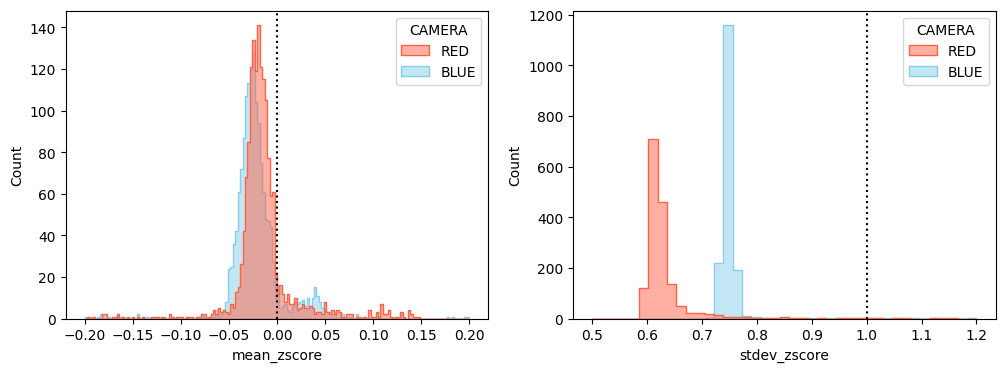

In [ ]:
plot_hist(stats_stack, mean_range=(-0.2, 0.2), stdev_range=(0.5, 1.2))

The mean flux in the sky-subtracted sky is significantly below zero, and the standard deviation of the sky is significantly below that expected from the errors.

Let's break it down by OB.

In [ ]:
# |export


def plot_dist(
    stats,
    by="OBID",
    mean_range=None,
    stdev_range=None,
    mean_bw=None,
    stdev_bw=None,
    sigma_clip=5.0,
    inner=None,
):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    if sigma_clip is not None:
        sigclip = sigmaclip(stats["mean_zscore"], sigma_clip, sigma_clip)
        ok = (stats["mean_zscore"] > sigclip.lower) & (
            stats["mean_zscore"] < sigclip.upper
        )
        mean_stats = stats[ok]
    else:
        mean_stats = stats
    sns.violinplot(
        ax=ax[0],
        data=mean_stats,
        x=by,
        y="mean_zscore",
        hue="CAMERA",
        density_norm="width",
        split=True,
        gap=0.2,
        inner=inner,
        palette=palette,
        saturation=1,
        bw_method=mean_bw,
        bw_adjust=0.5,
    )
    ax[0].axhline(0, c="k", ls=":")
    if mean_range is not None:
        ax[0].set_ylim(*mean_range)
    if sigma_clip is not None:
        sigclip = sigmaclip(stats["stdev_zscore"], sigma_clip, sigma_clip)
        ok = (stats["stdev_zscore"] > sigclip.lower) & (
            stats["stdev_zscore"] < sigclip.upper
        )
        stdev_stats = stats[ok]
    else:
        stdev_stats = stats
    sns.violinplot(
        ax=ax[1],
        data=stdev_stats,
        x=by,
        y="stdev_zscore",
        hue="CAMERA",
        density_norm="width",
        split=True,
        gap=0.2,
        inner=inner,
        palette=palette,
        saturation=1,
        bw_method=stdev_bw,
        bw_adjust=0.5,
    )
    ax[1].axhline(1, c="k", ls=":")
    if stdev_range is not None:
        ax[1].set_ylim(*stdev_range)
    fig.subplots_adjust(hspace=0.05)

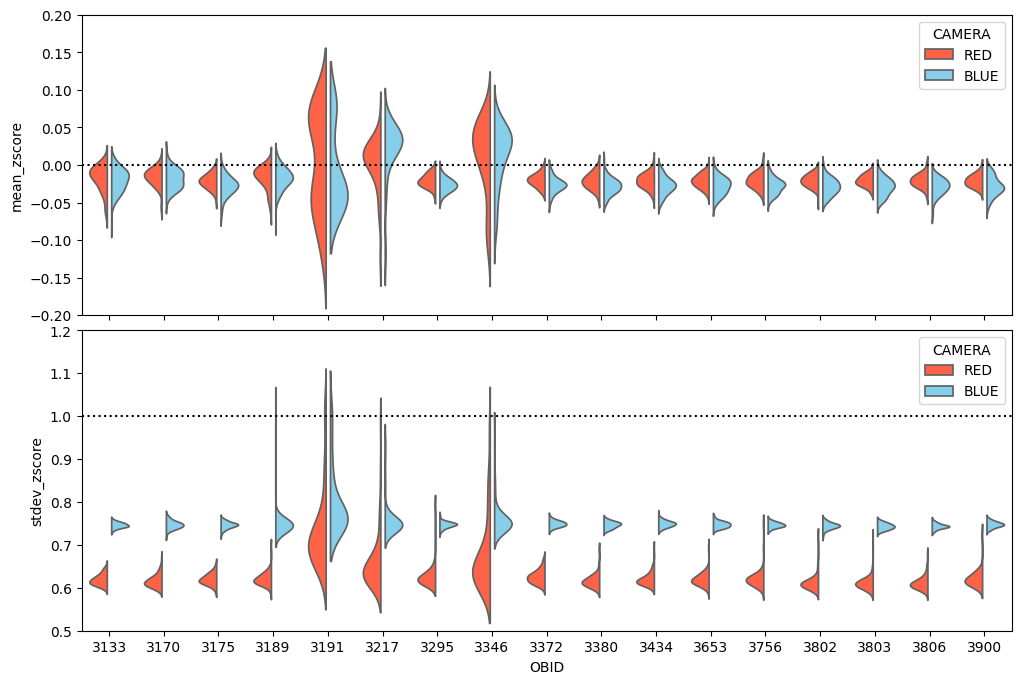

In [ ]:
plot_dist(
    stats_stack, mean_range=(-0.2, 0.2), stdev_range=(0.5, 1.2), mean_bw=1, stdev_bw=1
)

The same behaviour is seen for all OBs, apart from a few which show very broad distributions.

### Single observations

In [ ]:
dask_cluster = Client(n_workers=8, threads_per_worker=1, memory_limit="2GiB")
with dask_cluster as _:
    stats_single = tests_single.stats.to_pandas()
stats_single = stats_single.drop(columns=["RUN", "NSPEC", "filename"]).dropna()
stats_single

CAMERA           MJD     NIGHT  OBID  stdev_measured  \
RUN     NSPEC                                                        
1002213 11       RED  57639.865255  20160908  3191        6.530848   
        24       RED  57639.865255  20160908  3191        6.876608   
        28       RED  57639.865255  20160908  3191        6.576695   
        29       RED  57639.865255  20160908  3191        5.930667   
        30       RED  57639.865255  20160908  3191        5.989196   
...              ...           ...       ...   ...             ...   
1004150 547     BLUE  58027.195868  20170930  3936       12.288969   
        561     BLUE  58027.195868  20170930  3936       13.323919   
        567     BLUE  58027.195868  20170930  3936       12.312105   
        581     BLUE  58027.195868  20170930  3936       12.971208   
        596     BLUE  58027.195868  20170930  3936       12.668753   

               stdev_expected  mean_zscore  stdev_zscore  err_on_mean_zscore  \
RUN     NSPEC                                                                  
1002213 11           9.903826     0.004332      0.632706            0.005201   
        24          10.628039     0.017358      0.622439            0.005117   
        28          11.682731     0.025585      0.608206            0.005000   
        29           9.438472     0.066189      0.642155            0.005279   
        30           9.864829     0.047176      0.628069            0.005163   
...                       ...          ...           ...                 ...   
1004150 547         14.835949    -0.035239      0.890939            0.013070   
        561         14.854663    -0.005482      0.886231            0.012999   
        567         14.828223    -0.041646      0.895168            0.013132   
        581         14.846780    -0.025220      0.901099            0.013220   
        596         14.827168    -0.056254      0.902742            0.013244   

               err_on_stdev_zscore  sig_mean_zscore  sig_stdev_zscore  \
RUN     NSPEC                                                           
1002213 11                0.003678         0.832840         99.861802   
        24                0.003618         3.392516        104.353498   
        28                0.003535         5.117397        110.821595   
        29                0.003733        12.538981         95.867471   
        30                0.003651         9.137824        101.879522   
...                            ...              ...               ...   
1004150 547               0.009243         2.696268         11.799818   
        561               0.009193         0.421754         12.375995   
        567               0.009286         3.171409         11.288642   
        581               0.009349         1.907710         10.578802   
        596               0.009366         4.247448         10.384169   

                     ks_prob  
RUN     NSPEC                 
1002213 11     4.281802e-183  
        24     3.658854e-195  
        28     1.657524e-232  
        29     9.701559e-234  
        30     1.397214e-228  
...                      ...  
1004150 547     2.363494e-07  
        561     1.253771e-06  
        567     2.010916e-07  
        581     1.294121e-07  
        596     1.070085e-08  

[11178 rows x 13 columns]

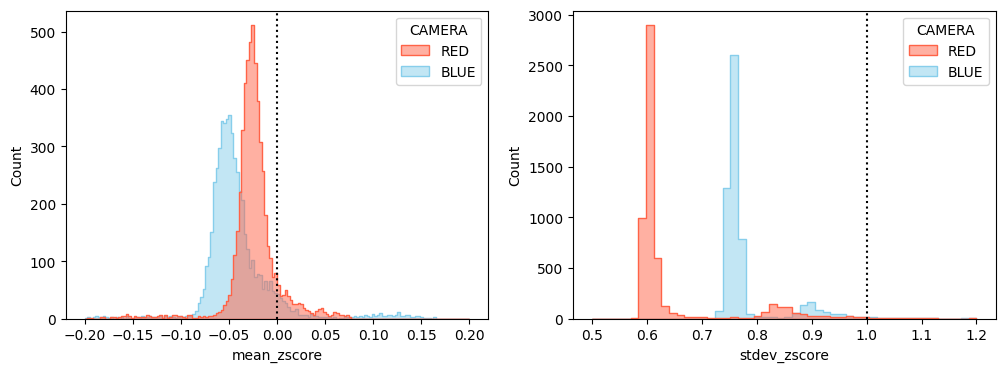

In [ ]:
plot_hist(stats_single, mean_range=(-0.2, 0.2), stdev_range=(0.5, 1.2))

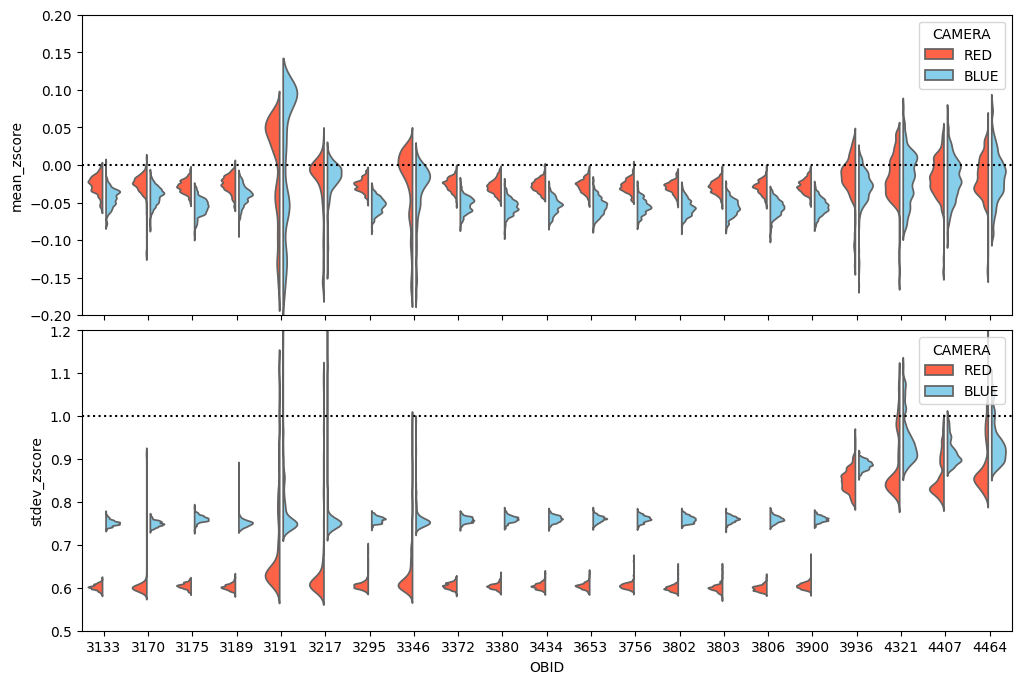

In [ ]:
plot_dist(stats_single, mean_range=(-0.2, 0.2), stdev_range=(0.5, 1.2))

A similar pattern to the stacks, although for some reason we don't have stacks for all the OBS.

### Compare noise level in stacks and singles

In [ ]:
stack_over_single = (
    stats_stack.set_index(["OBID", "CAMERA"])[["stdev_measured", "stdev_expected"]]
    / stats_single.set_index(["OBID", "CAMERA"])[["stdev_measured", "stdev_expected"]]
)

In [ ]:
stack_over_single = stack_over_single.dropna()
stack_over_single

stdev_measured  stdev_expected
OBID CAMERA                                
3133 BLUE          1.730016        1.732364
     BLUE          1.871599        1.882437
     BLUE          1.413495        1.451536
     BLUE          1.517625        1.521315
     BLUE          1.836264        1.853856
...                     ...             ...
3900 RED           2.221029        1.820005
     RED           2.285764        1.895699
     RED           1.914870        1.688769
     RED           2.007282        1.781666
     RED           1.980907        1.731235

[954006 rows x 2 columns]

In [ ]:
# |export


def plot_stack_over_single(df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(
        ax=ax[0],
        data=df,
        x="stdev_measured",
        hue="CAMERA",
        binrange=(1, 3),
        element="step",
        palette=palette,
        alpha=0.5,
    )
    ax[0].axvline(np.sqrt(3), c="k", ls=":")
    ax[0].set_xlabel("stack / single noise from measured flux")
    sns.histplot(
        ax=ax[1],
        data=df,
        x="stdev_expected",
        hue="CAMERA",
        binrange=(1, 3),
        element="step",
        palette=palette,
        alpha=0.5,
    )
    ax[1].axvline(np.sqrt(3), c="k", ls=":")
    ax[1].set_xlabel("stack / single noise from flux errors")

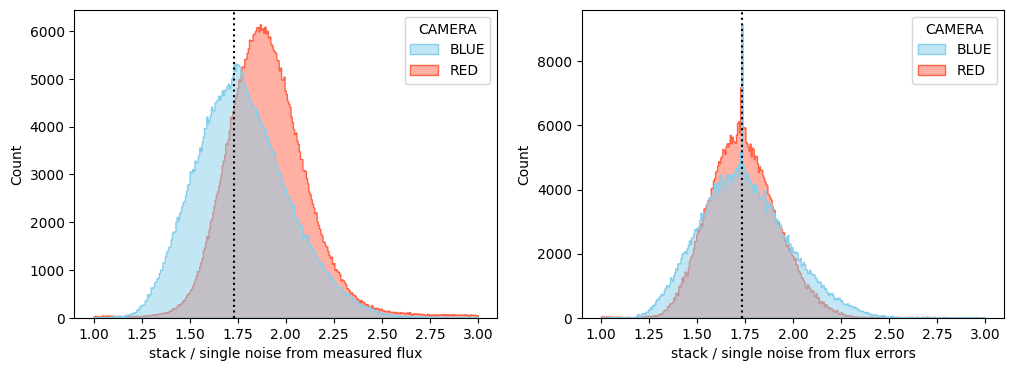

In [ ]:
plot_stack_over_single(stack_over_single)

The noise increases by a factor of $\sqrt{3}$, as expected for stacks that are the sum of three single exposures. However, there is sign of an additional contribution to the measured noise in the red stacks.

In [ ]:
# |hide
import nbdev

nbdev.nbdev_export()